In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
x_range = [-10, 10]
x_diff = x_range[1] - x_range[0]
def plot_func(func):
    x = np.arange(x_range[0], x_range[1], 0.01)
    y = func(x)
    plt.plot(x, y)

In [4]:
def plot_points(x, y):
    plt.xlim(x_range[0], x_range[1])
    plt.scatter(x, y)

In [94]:
def gpr_plot(func, x_train, y_train, x_test, mu, var):
    x = np.arange(x_range[0], x_range[1], 0.01)
    y = func(x)
    plt.plot(x, y)
    plt.scatter(x_train, y_train, color='orange')
    plt.scatter(x_test, mu+2*np.sqrt(var), color='green', s=25)
    plt.scatter(x_test, mu-2*np.sqrt(var), color='green', s=25)
    plt.scatter(x_test, mu, color='black', marker='x')

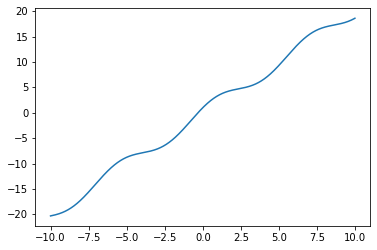

In [95]:
#target_func = lambda x: x*x
target_func = lambda x: 2*x + np.sin(x) + np.cos(x)
plot_func(target_func)

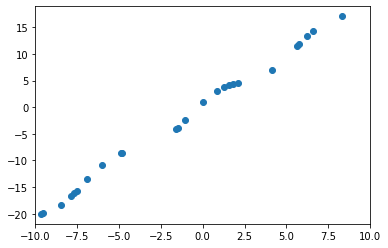

In [96]:
get_sample = lambda num: (x_range[1] - x_range[0]) * np.random.rand(num, 1) + x_range[0]

n_sample = 25
x_train = get_sample(n_sample)
y_train = target_func(x_train)
plot_points(x_train, y_train)


In [97]:
def gauss_kernel(x1, x2, theta1, theta2):
    return theta1 * np.exp(-(x1 - x2)*(x1 - x2) / theta2)

In [98]:
def gpr(x_test, x_train, y_train, kernel):
    n_train = len(x_train)
    n_test = len(x_test)
    K = np.zeros((n_train, n_train))
    k = np.zeros((n_train, n_test))
    s = np.zeros((n_test, n_test))
    for i in range(n_train):
        for j in range(n_train):
            K[i][j] = kernel(x_train[i], x_train[j])
    K_inv = np.linalg.inv(K)
    for i in range(n_train):
        for j in range(n_test):
            k[i][j] = kernel(x_train[i], x_test[j])
    for i in range(n_test):
        for j in range(n_test):
            s[i][j] = kernel(x_test[i], x_test[j])
    mu = k.T @ K_inv @ y_train
    _var = s - k.T @ K_inv @ k
    var = np.zeros(n_test)
    for i in range(n_test):
        var[i] = _var[i][i]
    return mu.reshape(-1), var

def gpr_flat(x_test, x_train, y_train, kernel):
    n_train = len(x_train)
    n_test = len(x_test)
    K = np.zeros((n_train, n_train))
    for i in range(n_train):
        for j in range(n_train):
            K[i][j] = kernel(x_train[i], x_train[j])
    K_inv = np.linalg.inv(K)
    mu = np.zeros((n_test))
    var = np.zeros((n_test))
    for i in range(n_test):
        k = np.zeros((n_train))
        for j in range(n_train):
            k[j] = kernel(x_test[i], x_train[j])
        s = kernel(x_test[i], x_test[i])
        mu[i] = k.T @ K_inv @ y_train
        var[i] = s - k.T @ K_inv @ k
    return mu, var



In [111]:
def gpr_plot_all(func, x_train, y_train, x_test, kernel):
    mu, var = gpr(x_test, x_train, y_train, kernel)
    x = np.arange(x_range[0], x_range[1], 0.01)
    y = func(x)
    plt.plot(x, y, color='red')
    plt.plot(x_test, mu, 'b-')
    plt.fill_between(x_test, mu-2*np.sqrt(var), mu+2*np.sqrt(var), color='#ccccff')
    plt.scatter(x_train, y_train, color='black', marker='x', s=100)

In [119]:
## train hyperparameters
## log p(y|x, t) = -log|K_t| - y^T @ K^-1 @ y  --> max_t

def evidence(x, y, theta):
    kernel = lambda x1, x2, theta: gauss_kernel(x1, x2, theta[0], theta[1])
    n_train = len(y)
    K = np.zeros((n_train, n_train))
    for i in range(n_train):
        for j in range(n_train):
            K[i][j] = kernel(x[i], x[j], theta)
    K_inv = np.linalg.inv(K)
    det = np.linalg.det(K)
    ev = -np.log(det) - y.T @ K_inv @ y
    if ev == np.nan or ev == np.inf:
        return -1e18
    return ev

## p = e^target_func(init_theta)
def mcmc_opt(init_theta, target_func, step, iter):
    theta = init_theta
    cur_p = np.exp(target_func(init_theta))
    #print(target_func(init_theta))
    eps = 1e-5
    for k in range(iter):
        r = np.random.rand(2) * 2*step - step
        next_theta = theta + r + eps
        #print(next_theta)
        ev = target_func(next_theta)
        nex_p = np.exp(ev)
        prob = np.random.rand()
        #print(f'prob={prob}, rhs={nex_p/cur_p}')
        if prob < (nex_p/cur_p):
            theta = next_theta
            cur_p = nex_p
        #print(target_func(theta))
    return theta

## TODO: overflow
#evidence(x_train, y_train, [150.0, 0.4])
target_func = lambda theta: evidence(x_train, y_train, theta)
init_theta = [100.0, 0.4]
step = 1.0
iter = 100
theta = mcmc_opt(init_theta, target_func, step, iter)
print(theta)

<ipython-input-97-d345440454dc>:2: RuntimeWarning: overflow encountered in exp
  return theta1 * np.exp(-(x1 - x2)*(x1 - x2) / theta2)
/home/kuramochi/.local/lib/python3.8/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
<ipython-input-119-beb3aae3e70e>:13: RuntimeWarning: invalid value encountered in log
  ev = -np.log(det) - y.T @ K_inv @ y


[102.39574584  11.71671369]


In [104]:
## TODO: theta
#kernel = lambda x1, x2: gauss_kernel(x1, x2, 1.0, 0.4)
kernel = lambda x1, x2: gauss_kernel(x1, x2, theta[0], theta[1])
x_test = get_sample(15)
mu, var = gpr_flat(x_test, x_train, y_train, kernel)
print(f'mu = {mu}, var = {var}')

mu = [-13.52157252   4.54938674  12.51159826  -5.00271625 -30.33076045
  -2.99905733  11.81255254  -2.8783242  -27.10678735  16.49492082
 -15.49804521  15.7730038    6.38142326   9.91301879 -21.45751068], var = [-18.81020379  50.45213628   1.39421149  90.61719547 -84.43060775
 164.09143738   8.20084571  79.8665747  -52.34133261  -0.46385945
 -20.39809213   1.46644076  15.89747201  -0.48020051 -30.37438477]


In [105]:
#gpr_plot(target_func, x_train, y_train, x_test, mu, var)

[-10.    -9.99  -9.98 ...   9.97   9.98   9.99]
[[nan]]


<ipython-input-100-32f320516348>:12: RuntimeWarning: invalid value encountered in log
  ev = -np.log(np.linalg.det(K)) - y.T @ K_inv @ y


ValueError: x and y must have same first dimension, but have shapes (2000,) and (1, 1)

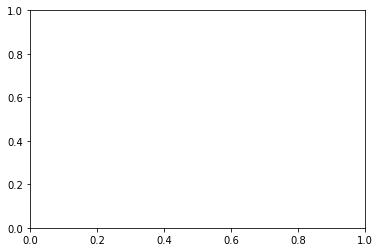

In [112]:
x_test_all = np.linspace(x_range[0], x_range[1], 100)
gpr_plot_all(target_func, x_train, y_train, x_test_all, kernel)